# LID heuristic vs. reconstruction loss
This notebook mirrors the edge-ratio analysis: we join per-image LID estimates with reconstruction losses for fixed token counts (k), then visualize their relationship with clear, commented code.

In [1]:
"""
Objective: Plot reconstruction loss versus LID (Local Intrinsic Dimensionality) for fixed k values.
This mirrors the edge-ratio analysis and assumes:
- Reconstruction metrics are stored in ../data/datasets/reconstruction_loss_imgnet_train/reconstruction_errors_all.json
- LID values are stored as an ordered list aligned with dataset indices, e.g.:
  ../data/datasets/imageNet_LID_values/train_imageNet_lid_values.json
If your LID path differs, update LID_JSON below.
"""
import json
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import math
sys.path.append(os.path.abspath(".."))  # allow relative imports if needed
print(os.path.abspath(".."))

/BS/data_mani_compress/work/thesis/thesis


In [2]:
# Paths (adjust if your files differ)
RECON_JSON = "/BS/data_mani_compress/work/thesis/thesis/data/datasets/imagenet_reconstruction_losses_new/all_reconstruction_losses.json"
LID_JSON   = "/BS/data_mani_compress/work/thesis/thesis/data/datasets/imageNet_LID_values/training_set/all_lids.json"
print('Using:', RECON_JSON)
print('Using:', LID_JSON)

# Load reconstruction dataset (list of dicts with fields: image_id, k_value, vgg_error, mse_error, ...)
with open(RECON_JSON, 'r') as f:
    reconstruction_dataset = json.load(f)

# Load LID values; we assume it's ordered so that index i corresponds to image i
with open(LID_JSON, 'r') as f:
    lid_values = json.load(f)

print('Sizes:', len(lid_values), len(reconstruction_dataset))

Using: /BS/data_mani_compress/work/thesis/thesis/data/datasets/imagenet_reconstruction_losses_new/all_reconstruction_losses.json
Using: /BS/data_mani_compress/work/thesis/thesis/data/datasets/imageNet_LID_values/training_set/all_lids.json
Sizes: 992000 11530503


In [3]:
# Build dataset-index -> LID lookup.
# The LID file can be a list of numbers or a list of dicts; we extract a numeric value.
lid_by_id = {}
for idx, item in enumerate(lid_values):
    lid_by_id[idx] = float(item)

len(lid_by_id)

992000

Using loss_key=LPIPS; ks=[1, 2, 4, 8, 16, 32, 64, 128, 256]


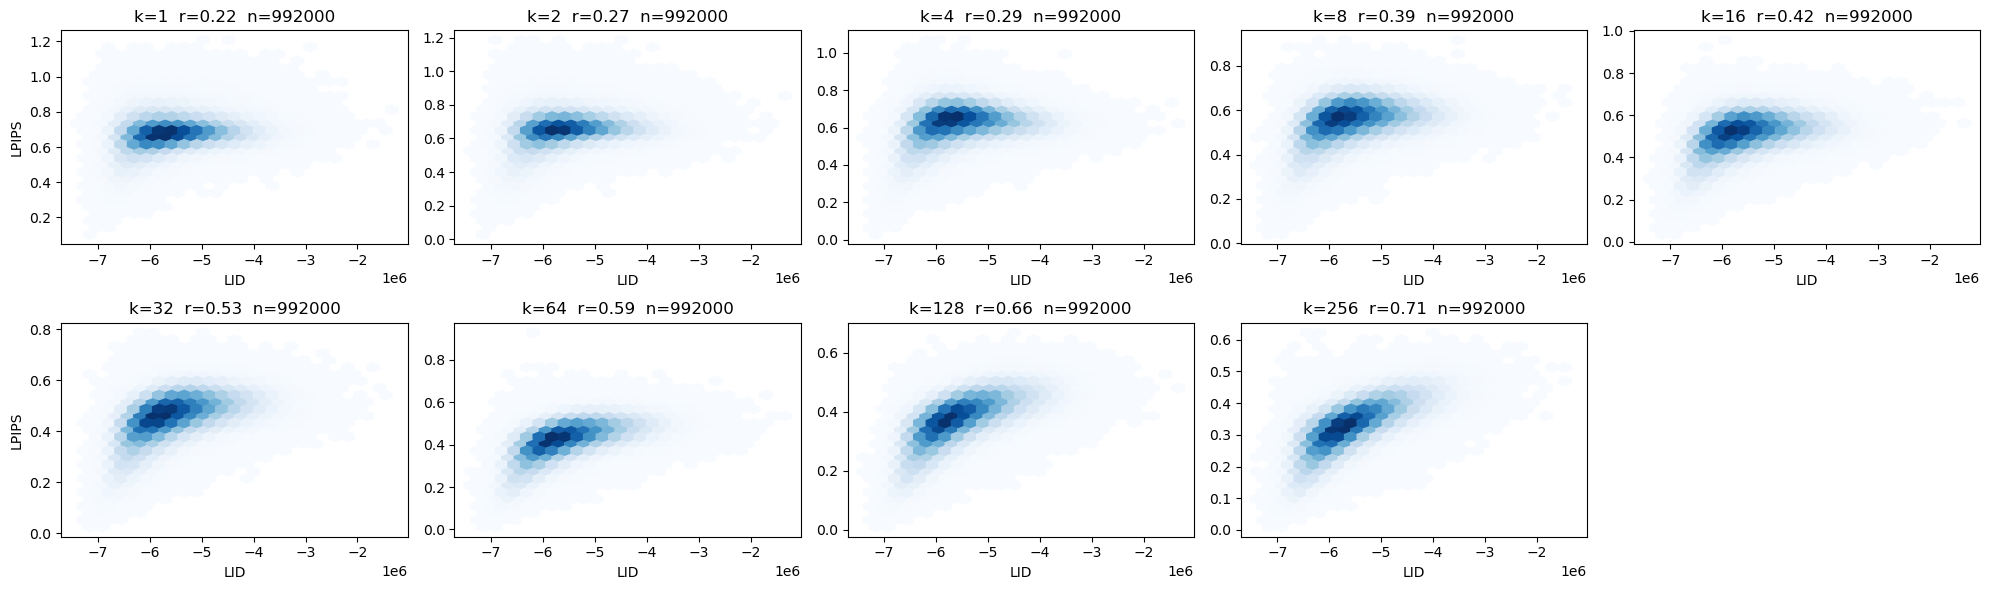

{1: {'n': 992000, 'pearson_r': 0.21566610057964516},
 2: {'n': 992000, 'pearson_r': 0.2706918336311453},
 4: {'n': 992000, 'pearson_r': 0.2870773275293055},
 8: {'n': 992000, 'pearson_r': 0.38544676330875655},
 16: {'n': 992000, 'pearson_r': 0.4228916898873197},
 32: {'n': 992000, 'pearson_r': 0.5310098758009145},
 64: {'n': 992000, 'pearson_r': 0.585160950587879},
 128: {'n': 992000, 'pearson_r': 0.6622711811723783},
 256: {'n': 992000, 'pearson_r': 0.7148644644262874}}

In [8]:
# Plot: for each k, scatter LID (x) vs reconstruction loss (y) with a binned trend and correlation.
# This mirrors the edge-ratio grid, with thorough comments for clarity.
# Parameters: choose which reconstruction loss to plot and which k values to include
loss_key = 'LPIPS'                 # or 'mse_error'
ks = [1, 2, 4, 8, 16, 32, 64, 128, 256]  # token counts to visualize
print(f"Using loss_key={loss_key}; ks={ks}")

ncols = 5
nrows = int(math.ceil(len(ks) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 3), squeeze=False)
axes_f = axes.flatten()

per_k_stats = {}  # {k: {'n': count, 'pearson_r': r}}
for i, k in enumerate(ks):
    ax = axes_f[i]

    # Gather pairs (x=LID, y=loss) for images that match this k and have a LID value
    xs_list, ys_list = [], []
    for rec in reconstruction_dataset:
        if int(rec['k_value']) != int(k):
            continue
        img_id = int(rec['image_id'])
        if img_id not in lid_by_id:
            continue
        xs_list.append(lid_by_id[img_id])       # x-axis: LID
        ys_list.append(float(rec[loss_key]))    # y-axis: reconstruction loss

    xs = np.array(xs_list, dtype=float)
    ys = np.array(ys_list, dtype=float)

    if xs.size > 0:
        # Scatter: small markers + transparency to handle dense plots
        ax.hexbin(xs, ys, gridsize=25, cmap='Blues', mincnt=1)

        # Pearson correlation (linear association); guard against zero variance
        corr = float('nan')
        if xs.size > 1 and np.std(xs) > 0 and np.std(ys) > 0:
            corr = np.corrcoef(xs, ys)[0, 1]
        per_k_stats[int(k)] = {'n': int(xs.size), 'pearson_r': corr}
        ax.set_title(f"k={k}  r={corr:.2f}  n={xs.size}")
    else:
        per_k_stats[int(k)] = {'n': 0, 'pearson_r': float('nan')}
        ax.set_title(f"k={k} (no data)")

    # Label axes (reduce clutter: y-label only on first column)
    if i % ncols == 0:
        ax.set_ylabel(loss_key.replace('_', ' '))  # e.g., 'vgg error' or 'mse error'
    ax.set_xlabel('LID')

# Hide any leftover axes in the grid (when ks doesn't fill all slots)
for j in range(len(ks), len(axes_f)):
    axes_f[j].axis('off')

plt.tight_layout()
plt.show()

per_k_stats

Using loss_key=L1Loss; ks=[1, 2, 4, 8, 16, 32, 64, 128, 256]


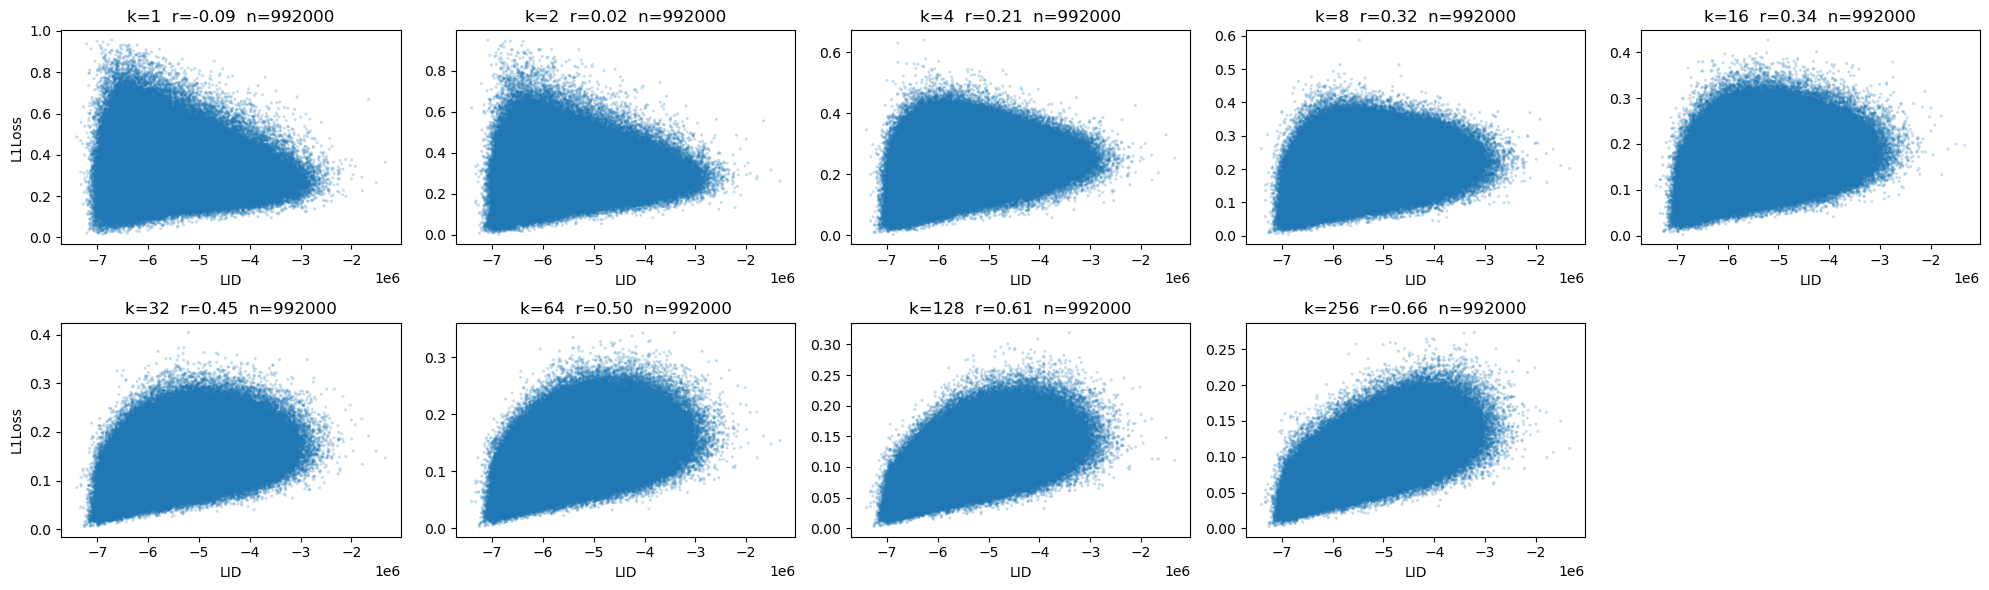

{1: {'n': 992000, 'pearson_r': -0.08927707425009263},
 2: {'n': 992000, 'pearson_r': 0.01800672590207122},
 4: {'n': 992000, 'pearson_r': 0.2070070084957572},
 8: {'n': 992000, 'pearson_r': 0.31864478828340154},
 16: {'n': 992000, 'pearson_r': 0.3427304789411071},
 32: {'n': 992000, 'pearson_r': 0.44530298057065126},
 64: {'n': 992000, 'pearson_r': 0.5038435489224111},
 128: {'n': 992000, 'pearson_r': 0.6060856905391344},
 256: {'n': 992000, 'pearson_r': 0.6582167528933792}}

In [6]:
# Plot: for each k, scatter LID (x) vs reconstruction loss (y) with a binned trend and correlation.
# This mirrors the edge-ratio grid, with thorough comments for clarity.
# Parameters: choose which reconstruction loss to plot and which k values to include
loss_key = 'L1Loss'                 # or 'mse_error'
ks = [1, 2, 4, 8, 16, 32, 64, 128, 256]  # token counts to visualize
print(f"Using loss_key={loss_key}; ks={ks}")

ncols = 5
nrows = int(math.ceil(len(ks) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 3), squeeze=False)
axes_f = axes.flatten()

per_k_stats = {}  # {k: {'n': count, 'pearson_r': r}}
for i, k in enumerate(ks):
    ax = axes_f[i]

    # Gather pairs (x=LID, y=loss) for images that match this k and have a LID value
    xs_list, ys_list = [], []
    for rec in reconstruction_dataset:
        if int(rec['k_value']) != int(k):
            continue
        img_id = int(rec['image_id'])
        if img_id not in lid_by_id:
            continue
        xs_list.append(lid_by_id[img_id])       # x-axis: LID
        ys_list.append(float(rec[loss_key]))    # y-axis: reconstruction loss

    xs = np.array(xs_list, dtype=float)
    ys = np.array(ys_list, dtype=float)

    if xs.size > 0:
        # Scatter: small markers + transparency to handle dense plots
        ax.scatter(xs, ys, s=5, alpha=0.25, edgecolors='none')

        # Pearson correlation (linear association); guard against zero variance
        corr = float('nan')
        if xs.size > 1 and np.std(xs) > 0 and np.std(ys) > 0:
            corr = np.corrcoef(xs, ys)[0, 1]
        per_k_stats[int(k)] = {'n': int(xs.size), 'pearson_r': corr}
        ax.set_title(f"k={k}  r={corr:.2f}  n={xs.size}")
    else:
        per_k_stats[int(k)] = {'n': 0, 'pearson_r': float('nan')}
        ax.set_title(f"k={k} (no data)")

    # Label axes (reduce clutter: y-label only on first column)
    if i % ncols == 0:
        ax.set_ylabel(loss_key.replace('_', ' '))  # e.g., 'vgg error' or 'mse error'
    ax.set_xlabel('LID')

# Hide any leftover axes in the grid (when ks doesn't fill all slots)
for j in range(len(ks), len(axes_f)):
    axes_f[j].axis('off')

plt.tight_layout()
plt.show()

per_k_stats